In [10]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg
from scipy.signal import welch

import puv 

In [11]:
x = 22.2+22.91+23.19+23.83
print(x)

92.13


In [12]:
from netCDF4 import Dataset

file_path = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\RBR_05\tailored\RBR_05.nc"
# file_path = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\Hybrid_Dune\Pressure_sensors\S1\OSSI_04\tailored\OSSI_04.nc"

ds = xr.open_dataset(file_path)

In [13]:
ds

<xarray.Dataset> Size: 408MB
Dimensions:           (t: 432, N: 19200, f: 480)
Coordinates:
  * t                 (t) datetime64[ns] 3kB 2024-12-16T09:00:00 ... 2024-12-...
  * N                 (N) float64 154kB 0.0 0.0625 0.125 ... 1.2e+03 1.2e+03
  * f                 (f) float64 4kB 0.0 0.01667 0.03333 ... 7.95 7.967 7.983
Data variables: (12/38)
    p                 (t, N) float64 66MB ...
    zi                float64 8B ...
    zb                float64 8B ...
    sf                float64 8B ...
    name              <U6 24B ...
    h                 (t) float64 3kB ...
    ...                ...
    Tm02_high         (t) float64 3kB ...
    Tmm10_high        (t) float64 3kB ...
    Tps_high          (t) float64 3kB ...
    Sk                (t) float64 3kB ...
    As                (t) float64 3kB ...
    sig               (t) float64 3kB ...
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      RBR_05
    instrument:                RBR_05
    instrument type:           Ruskin RBR Solo
    instrument serial number:  202438
    epsg:                      28992
    ...                        ...
    summary:                   Hybrid-Dune campaign, pressure corrected for a...
    contact person:            Ruben Rosman
    emailadres:                r.g.c.rosman@student.tudelft.nl
    construction datetime:     13-Feb-2025 (09:46:41)
    version:                   v1
    version comments:          constructed with xarray

C:\Users\ruro\AppData\Local\Temp\ipykernel_16484\1790777950.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


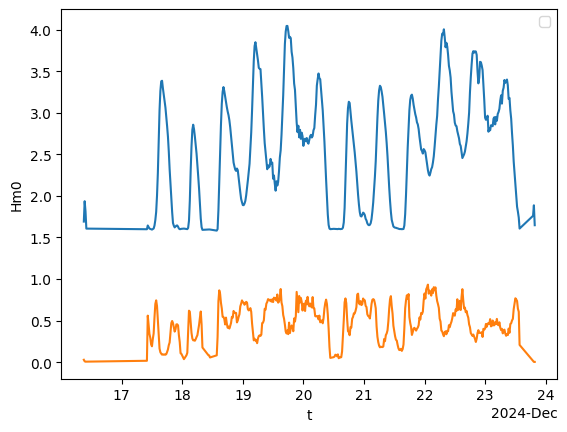

In [14]:
ds.h.plot()
ds.Hm0.plot()
plt.legend()

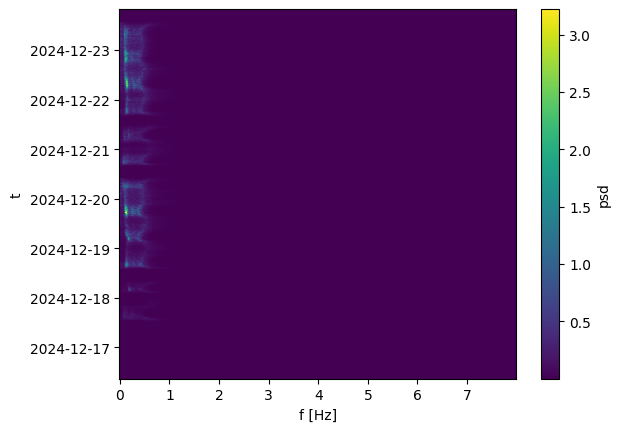

In [15]:
ds.psd.plot()

In [16]:
def find_time_index(ds, specific_time):
    """
    Function to find the index 't' for a specific time in the dataset.
    
    Parameters:
    ds (xarray.Dataset): The dataset containing the time dimension.
    specific_time (str or datetime): The specific time to find the index for.
    
    Returns:
    int: The index corresponding to the specific time.
    """
    specific_time = np.datetime64(specific_time)
    time_index = np.where(ds.t.values == specific_time)[0]
    
    if len(time_index) == 0:
        raise ValueError(f"Time {specific_time} not found in the dataset.")
    
    return time_index[0]

# Example usage
specific_time = "2024-12-22T07:00:00"
t_index = find_time_index(ds, specific_time)
print(f"The index for the specific time {specific_time} is {t_index}.")

The index for the specific time 2024-12-22T07:00:00 is 336.


fresolution is: 0.016666666666666666


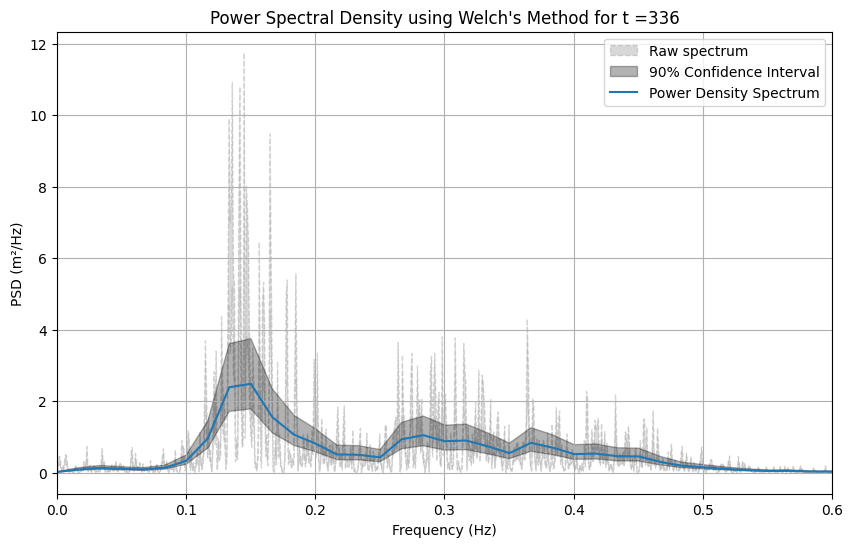

In [17]:
from scipy.stats import chi2
t=336
sf=16
freq = ds.frequencies.isel(t=t)
psd = ds.psd.isel(t=t)
p_blocks = 20
D_length = 1200
fresolution = p_blocks / D_length
print(f'fresolution is: {fresolution}')
nperseg = D_length * sf / p_blocks - 0.5


# Calculate confidence intervals
# nBlocks = len(ds.zs.isel(t=t)) // nperseg  # Estimate the number of blocks used by Welch's method
nBlocks = 20
edf = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
alpha = 0.1                  # 90% confidence level

confLow = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit

# Confidence interval bounds for PSD
psd_lower = psd * confLow
psd_upper = psd * confUpper

plt.figure(figsize=(10, 6))

### background plot 
freq_bg, psd_bg = welch(ds.zs.isel(t=t).values, fs=16, nperseg=19200, detrend='constant', window='hann')
nBlocks_bg = len(ds.zs.isel(t=t).values) // 19200  # Estimate the number of blocks used by Welch's method
edf_bg = round(nBlocks * 2)     # Degrees of freedom (approximately 2 per segment)
confLow_bg = edf / chi2.ppf(1 - alpha / 2, edf)  # Lower confidence limit
confUpper_bg = edf / chi2.ppf(alpha / 2, edf)    # Upper confidence limit
psd_lower_bg = psd_bg * confLow_bg
psd_upper_bg = psd_bg * confUpper_bg
# plt.plot(freq_bg, psd_upper_bg, color='gray', linestyle= '--')
plt.fill_between(freq_bg, psd_lower_bg, psd_upper_bg, color='gray', alpha=0.3, label='Raw spectrum', linestyle='--')

### plotting
plt.fill_between(freq, psd_lower, psd_upper, color='black', alpha=0.3, label='90% Confidence Interval')
plt.semilogy(freq, psd, label='Power Density Spectrum')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (m²/Hz)')
plt.title(f'Power Spectral Density using Welch\'s Method for t ={t}')
plt.grid()
plt.yscale('linear')
# plt.xscale('log')
plt.xscale('linear')
plt.xlim(0,0.6)
plt.legend()
plt.show()

In [18]:
import matplotlib.pyplot as plt


# Create a continuous time array
t_continuous = np.array([t + np.timedelta64(int(n), 's') for t in ds.t.values for n in ds.N.values])

# Flatten the burst structure for plotting
zs_flat = ds.zs.values.flatten()
zs_low_flat = ds.zs_low.values.flatten()
zs_high_flat = ds.zs_high.values.flatten()

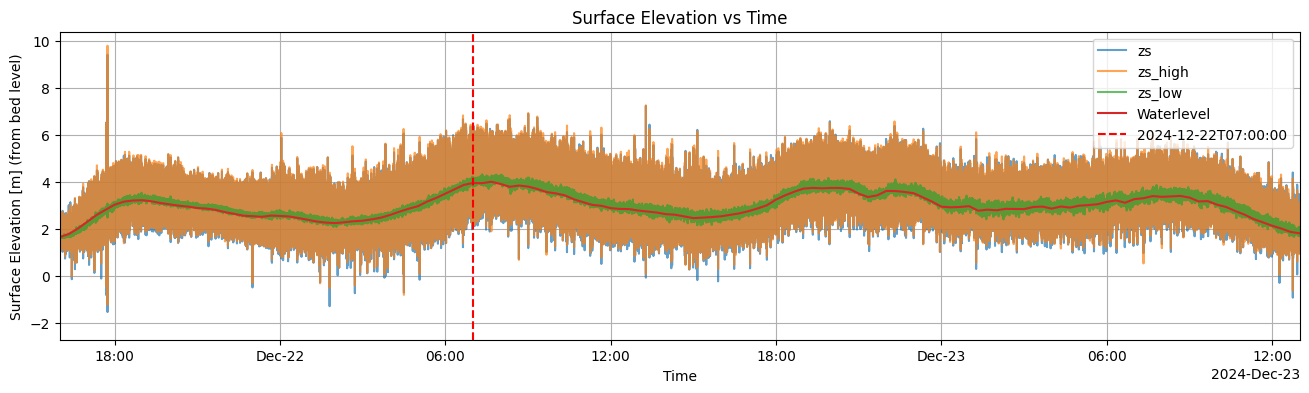

In [19]:
# Plotting
plt.figure(figsize=(16, 4))

plt.plot(t_continuous, zs_flat, label='zs', alpha=0.7)
plt.plot(t_continuous, zs_high_flat, label='zs_high', alpha=0.7)
plt.plot(t_continuous, zs_low_flat, label='zs_low', alpha=0.7)

ds.h.plot(label='Waterlevel')

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
plt.xlim(start_time, end_time)

specific_time_dt = pd.to_datetime(specific_time)
plt.axvline(x=specific_time_dt, color='red', linestyle='--', label=f'{specific_time}')

plt.xlabel('Time')
plt.ylabel('Surface Elevation [m] (from bed level)')
plt.title('Surface Elevation vs Time')
plt.legend(loc='upper right')
plt.grid(True)
plt.show();

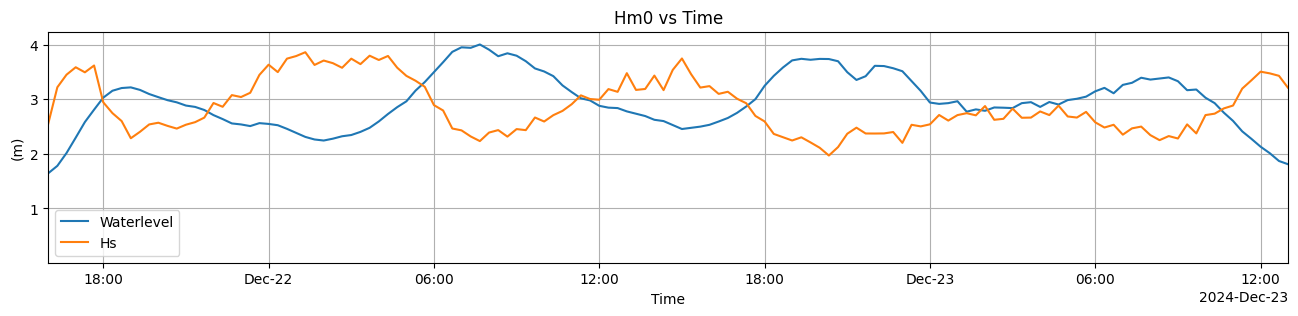

In [20]:
# plot hs and h
plt.figure(figsize=(16, 3))
ds.h.plot(label='Waterlevel')
plt.plot(ds.t, 4* np.sqrt(ds.Hm0), label='Hs')

# ds.Hm0_low.plot(label=f'Hm0_low (mean={ds.Hm0_low.mean().values:.3g} m)')

# ds.Hm0_high.plot(label='Hm0_high')
plt.legend()

plt.xlabel('Time')
plt.ylabel('(m)')
plt.title('Hm0 vs Time')
plt.grid(True)

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
plt.xlim(start_time, end_time)

plt.show()


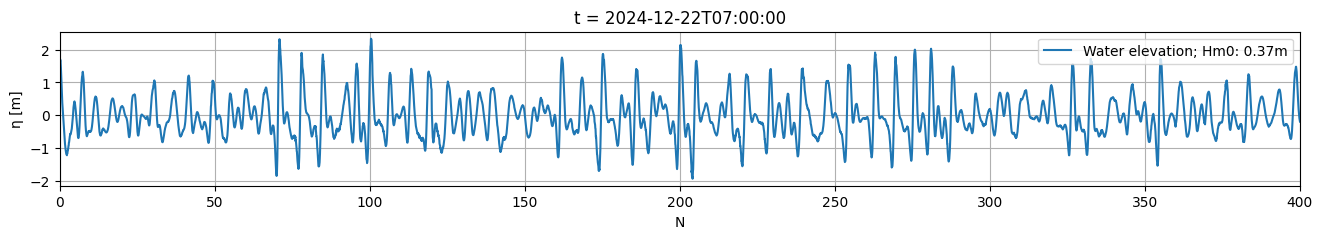

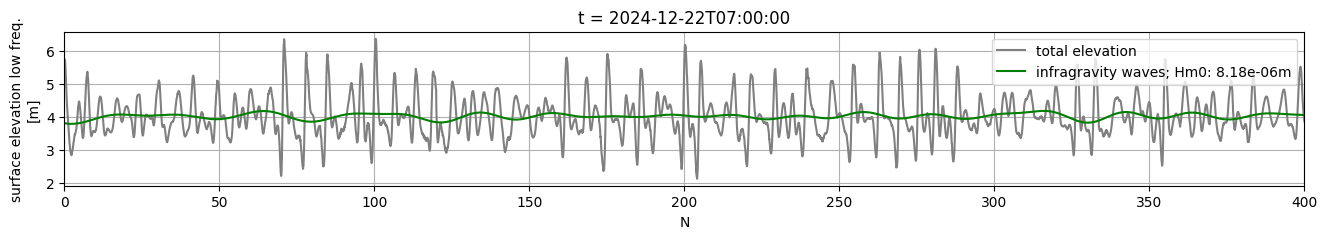

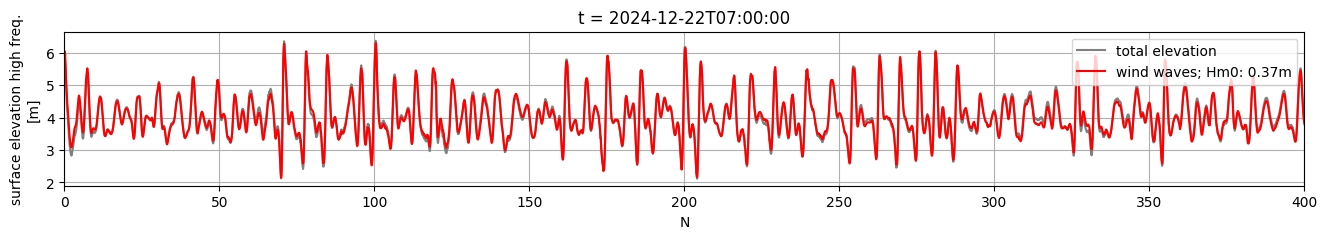

In [21]:
t = 336
end =400

plt.figure(figsize=(16, 2))
(ds.zs.isel(t=t)-ds.zs.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
# (ds.zs.isel(t=t)-ds.h.isel(t=t).mean()).plot(label = f'Water elevation; Hm0: {ds.Hm0.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.ylabel(f'\u03B7 [m]')
plt.legend(loc='upper right')

plt.figure(figsize=(16, 2))
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_low.isel(t=t).plot(color='green', label = f'infragravity waves; Hm0: {ds.Hm0_low.isel(t=t).values:.3g}m')
plt.grid()
plt.xlim(0,end)
plt.legend(loc='upper right')

plt.figure(figsize=(16, 2))
ds.zs.isel(t=t).plot(color='grey', label= 'total elevation')
ds.zs_high.isel(t=t).plot(color='red', label = f'wind waves; Hm0: {ds.Hm0_high.isel(t=t).values:.3g}m')

plt.grid()
plt.xlim(0,end)
plt.legend(loc='upper right');

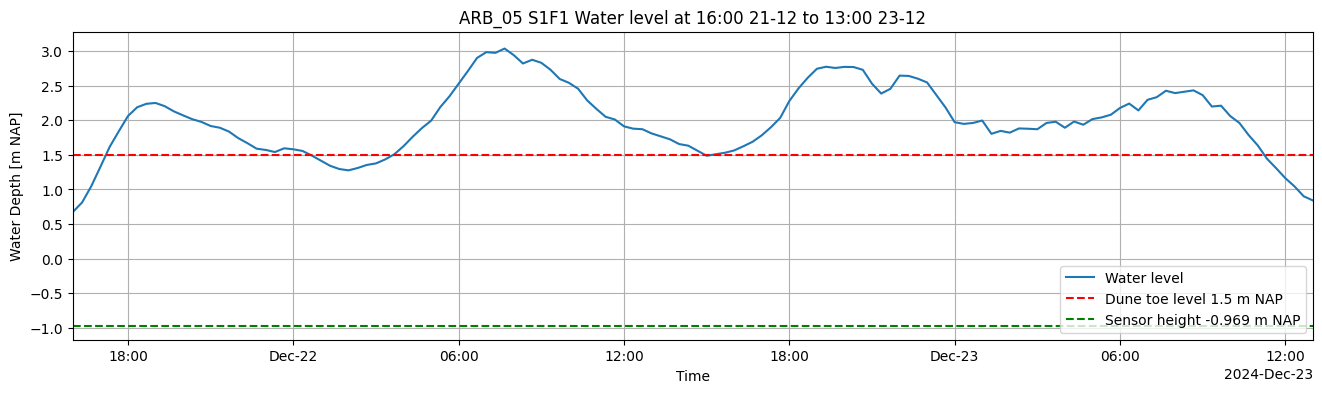

In [31]:
plt.figure(figsize=(16, 4))
(ds.h + ds.zb).plot(label='Water level')
plt.grid(True)

plt.title(f'ARB_05 S1F1 Water level at {start_time.strftime("%H:%M %d-%m")} to {end_time.strftime("%H:%M %d-%m")}')
# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
plt.xlim(start_time, end_time)

plt.axhline(y=1.5, color='red', linestyle='--', label='Dune toe level 1.5 m NAP')
plt.axhline(y=ds.zb.mean().values, color='green', linestyle='--', label=f'Sensor height {ds.zb.mean().values:.3g} m NAP')

plt.legend(loc='lower right')	
plt.xlabel('Time')
plt.ylabel('Water Depth [m NAP]');

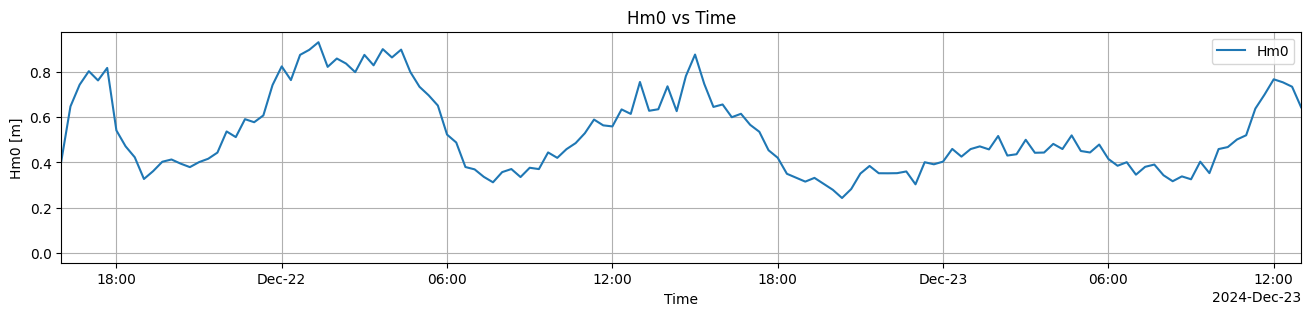

In [33]:
# plot hs and h
plt.figure(figsize=(16, 3))
# ds.h.plot(label='Waterlevel')
ds.Hm0.plot(label='Hm0')
plt.legend()


plt.xlabel('Time')
plt.ylabel('Hm0 [m]')
plt.title('Hm0 vs Time')
plt.grid(True)

# Set x-axis limits using specific date stamps
start_time = pd.Timestamp("2024-12-21T16:00:00")
end_time = pd.Timestamp("2024-12-23T13:00:00")
plt.xlim(start_time, end_time)
plt.show()
